In [1]:
import cmdstanpy
from cmdstanpy import CmdStanModel

In [2]:
%load_ext cmdstanjupyter

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")

In [5]:
df=pd.read_csv("../Data/data-ss1.txt")
df.index=df["X"]

,X,Y
0,1,11.2
1,2,11.0
2,3,11.3
3,4,10.8
4,5,10.8


<AxesSubplot:xlabel='X'>

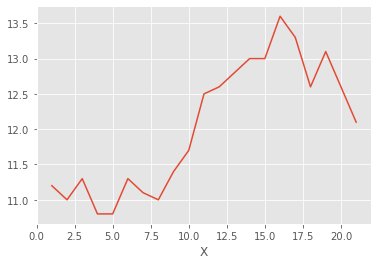

In [8]:
df["Y"].plot()

## 1階差分のトレンド項で予測するモデル

In [10]:
%%stan state_space_model
data {
  int T;
  int T_pred;
  vector[T] Y;
}

parameters {
  vector[T] mu;
  real<lower=0> s_mu;
  real<lower=0> s_Y;
}

model {
  mu[2:T] ~ normal(mu[1:(T-1)],s_mu);
  Y ~ normal(mu,s_Y);
}

generated quantities {
  vector[T+T_pred] mu_all;
  vector[T_pred] y_pred;
  mu_all[1:T]=mu;
  for (t in 1:T_pred){
    mu_all[T+t]=normal_rng(mu_all[T+t-1],s_mu);
    y_pred[t]= normal_rng(mu_all[T+t],s_Y);
  }
}

INFO:cmdstanjupyter:Writing model to .stan/state_space_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "state_space_model"
INFO:cmdstanpy:compiling stan program, exe file: /home/takato/NoteBook/stan/pr_cmdstan/NoteBook/.stan/state_space_model
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/takato/NoteBook/stan/pr_cmdstan/NoteBook/.stan/state_space_model
INFO:cmdstanjupyter:StanModel now available as variable "state_space_model"!
 Compilation took 21 seconds.


In [14]:
data={"T":len(df),"Y":df["Y"].values,"T_pred":3}
fit=state_space_model.sample(data=data
                        ,seed=1234,iter_warmup=1000,iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


In [16]:
fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpwbbmsoqu/state_space_model-202109262223-1-pd2djozo.csv, /tmp/tmpwbbmsoqu/state_space_model-202109262223-2-9xvsl21k.csv, /tmp/tmpwbbmsoqu/state_space_model-202109262223-3-a8774iee.csv, /tmp/tmpwbbmsoqu/state_space_model-202109262223-4-q0aqy57g.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.0860412, is below the nominal threshold of 0.3 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


'Processing csv files: /tmp/tmpwbbmsoqu/state_space_model-202109262223-1-pd2djozo.csv, /tmp/tmpwbbmsoqu/state_space_model-202109262223-2-9xvsl21k.csv, /tmp/tmpwbbmsoqu/state_space_model-202109262223-3-a8774iee.csv, /tmp/tmpwbbmsoqu/state_space_model-202109262223-4-q0aqy57g.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nThe E-BFMI, 0.0860412, is below the nominal threshold of 0.3 which suggests that HMC may have trouble exploring the target distribution.\nIf possible, try to reparameterize the model.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete.'

In [49]:
dfres=fit.summary(percentiles=[10,25,50,75,90],sig_figs=5) #sig_figsで有効数字調整できる
mu_col=[f"mu_all[{i}]" for i in range(1,24+1)]
pred_col=[f"y_pred[{i}]" for i in range(1,3+1)]
col=["10%","25%","50%","75%","90%"]
dfmu_all=dfres.loc[mu_col,col].reset_index()
dfy_pred=dfres.loc[pred_col,col].reset_index()

In [44]:
dfbase=df.reset_index(drop=True)

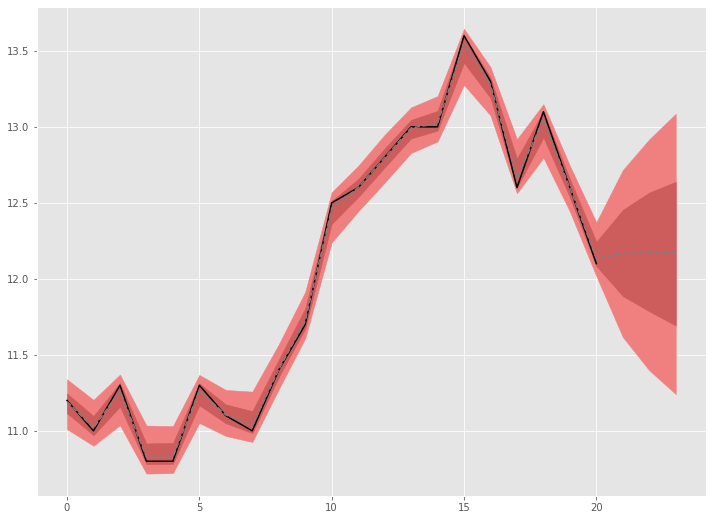

In [54]:
fig,ax=plt.subplots(figsize=(12,9))
dfbase["Y"].plot(c="k")
dfmu_all["50%"].plot(c="gray",ls="--")
ax.fill_between(dfmu_all.index,dfmu_all["10%"],dfmu_all["90%"],interpolate=True,color="lightcoral")
ax.fill_between(dfmu_all.index,dfmu_all["25%"],dfmu_all["75%"],interpolate=True,color="indianred")

## 2階差分のトレンド項で予測するモデル

In [55]:
%%stan state_space_model
data {
  int T;
  int T_pred;
  vector[T] Y;
}

parameters {
  vector[T] mu;
  real<lower=0> s_mu;
  real<lower=0> s_Y;
}

model {
  mu[3:T] ~ normal(2*mu[2:(T-1)]-mu[1:(T-2)],s_mu);
  Y ~ normal(mu,s_Y);
}

generated quantities {
  vector[T+T_pred] mu_all;
  vector[T_pred] y_pred;
  mu_all[1:T]=mu;
  for (t in 1:T_pred){
    mu_all[T+t]=normal_rng(2*mu_all[T+t-1] -mu_all[T+t-2],s_mu);
    y_pred[t]= normal_rng(mu_all[T+t],s_Y);
  }
}

INFO:cmdstanjupyter:Writing model to .stan/state_space_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "state_space_model"
INFO:cmdstanpy:compiling stan program, exe file: /home/takato/NoteBook/stan/pr_cmdstan/NoteBook/.stan/state_space_model
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/takato/NoteBook/stan/pr_cmdstan/NoteBook/.stan/state_space_model
INFO:cmdstanjupyter:StanModel now available as variable "state_space_model"!
 Compilation took 22 seconds.


In [56]:
data={"T":len(df),"Y":df["Y"].values,"T_pred":3}
fit=state_space_model.sample(data=data
                        ,seed=1234,iter_warmup=1000,iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [57]:
dfres=fit.summary(percentiles=[10,25,50,75,90],sig_figs=5) #sig_figsで有効数字調整できる
mu_col=[f"mu_all[{i}]" for i in range(1,24+1)]
pred_col=[f"y_pred[{i}]" for i in range(1,3+1)]
col=["10%","25%","50%","75%","90%"]
dfmu_all=dfres.loc[mu_col,col].reset_index()
dfy_pred=dfres.loc[pred_col,col].reset_index()

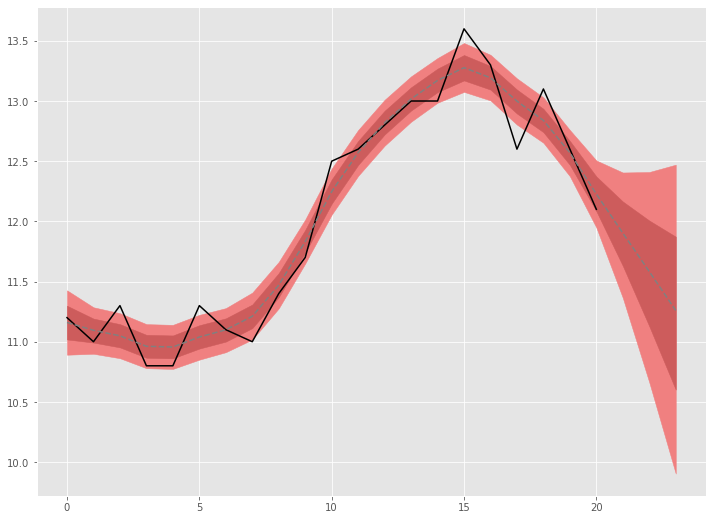

In [58]:
fig,ax=plt.subplots(figsize=(12,9))
dfbase["Y"].plot(c="k")
dfmu_all["50%"].plot(c="gray",ls="--")
ax.fill_between(dfmu_all.index,dfmu_all["10%"],dfmu_all["90%"],interpolate=True,color="lightcoral")
ax.fill_between(dfmu_all.index,dfmu_all["25%"],dfmu_all["75%"],interpolate=True,color="indianred")